In [1]:
import numpy as np

np.set_printoptions(
    suppress=True,
    linewidth=180
)

# Board generation

In [2]:
def generate_board(num_actions):
    import random
    actions = [
        {
            "id": i,
            "attackerCost": random.randint(1, 5),
            "defenderCost": random.randint(1, 5),
            "attackerProb": round(random.uniform(0.5, 0.98),2),
            "defenderProb": round(random.uniform(0.5, 0.98),2),
            "severity": random.randint(1,5),
        }
        for i in range(num_actions)
    ]
    for v in actions:
        v["risk"] = round(v["severity"] ** 2 * v["attackerProb"] * (1-v["defenderProb"]) * (v["defenderCost"] / v["attackerCost"]),2)
    return actions

# Utility matrix generation

In [3]:
def powerset(s):
    import itertools
    return itertools.chain.from_iterable(itertools.combinations(s, r) for r in range(1, len(s)+1))

In [4]:
def get_utility(attackerTurn, defenderTurn):
    defenderLabels = set([m["id"] for m in defenderTurn])
    return sum([
        action["severity"]**2 * action["attackerProb"]
        if action["id"] not in defenderLabels else
        action["severity"]**2 * action["attackerProb"] * (1-action["defenderProb"])
        for action in attackerTurn
    ])

In [5]:
def validate_cost(turn, cost_func, max_cost):
    return sum([cost_func(m) for m in turn]) <= max_cost

In [6]:
def generate_utility_matrices(
    board,
    attacker_cost_available,
    defender_cost_available,
    defender_knows_attacker_cost
):
    turns = list(powerset(board))
    attacker_utility_matrix = np.zeros((len(turns),len(turns)))
    defender_utility_matrix = np.zeros((len(turns),len(turns)))

    for i, attacker_choice in enumerate(turns):
        for j, defender_choice in enumerate(turns):
            # if the attacker turn is invalid
            if not validate_cost(attacker_choice, lambda x: x["attackerCost"], attacker_cost_available):
                # terrible attacker utility
                attacker_utility_matrix[i][j] = -999
                # if the defender turn is also invalid
                if not validate_cost(defender_choice, lambda x: x["defenderCost"], defender_cost_available):
                    # terrible defender utility
                    defender_utility_matrix[i][j] = -999
                else:
                    # utility is dependent on whether the defender knows the attacker max cost or not
                    defender_utility_matrix[i][j] = -999 if defender_knows_attacker_cost else -get_utility(attacker_choice, defender_choice)
            else:
                # normal attacker utility otherwise
                attacker_utility_matrix[i][j] = get_utility(attacker_choice, defender_choice)
                # if defender turn is invalid
                if not validate_cost(defender_choice, lambda x: x["defenderCost"], defender_cost_available):
                    # terrible defender utility
                    defender_utility_matrix[i][j] = -999
                else:
                    # normal defender utility otherwise
                    defender_utility_matrix[i][j] = -get_utility(attacker_choice, defender_choice)
    # return attacker_utility_matrix.transpose(), defender_utility_matrix
    return turns, attacker_utility_matrix.transpose(), defender_utility_matrix

# Optimization problem solver

In [7]:
def get_optimized_solution(util):
    import scipy.optimize
    
    # print(util.shape)

    c = np.zeros(util.shape[1]+1)
    c[0] = -1

    A_ub = np.ones((util.shape[0], util.shape[1] +1))
    A_ub[:,1:] = util*-1
    b_ub = np.zeros(util.shape[0])

    A_eq = np.ones((1, util.shape[1] + 1))
    A_eq[0][0] = 0
    b_eq = 1

    lb = np.zeros(util.shape[1]+1)
    lb[0] = -10000
    ub = np.ones(util.shape[1]+1)
    ub[0] = 10000
    bounds = np.asarray([lb, ub]).transpose()

    result = scipy.optimize.linprog(
        c=c,
        A_ub=A_ub,
        b_ub=b_ub,
        A_eq=A_eq,
        b_eq=b_eq,
        bounds=bounds,
        # options = {
        #     "tol": 0.001
        #     # "autoscale": True
        # }
        # method="simplex",
        method="highs",
        # method="interior-point",
        # options={"presolve":False},
        # callback = lambda x: zz.append(x.x)
    )
    if result.success:
        return result.x[1:]
    else:
        print(result)
        raise Exception("Couldn't find solution")

# get_optimized_solution(attacker_utility)

In [8]:
def get_average_solution(utility_matrix):
    x = utility_matrix.shape[1]
    return np.ones(x) / x

In [9]:
def get_risk(action):
    return action["severity"]**2 * action["attackerProb"] * (1-action["defenderProb"]) * (action["defenderCost"] / action["attackerCost"])

def get_knapsack_solution(turns):
    risks = [sum([get_risk(x) for x in turn]) for turn in turns]
    best = None
    
    for i, (risk, turn) in enumerate(zip(risks, turns)):
        if best is None or risk > risks[best]:
            best = i

    rtn = np.zeros(len(turns))
    rtn[best] = 1
    return rtn

# def get_knapsack_solution(board, costFunc):
#     from ortools.algorithms import pywrapknapsack_solver
#     y_defender_strat = []
#     values = [x["severity"]**2 * x["attackerProb"] * (1-x["defenderProb"]) * (x["defenderCost"] / x["attackerCost"]) for x in board]
#     values = [int(x*1000) for x in values]

#     weights = [x["defenderCost"] for x in board]

#     solver = pywrapknapsack_solver.KnapsackSolver(pywrapknapsack_solver.KnapsackSolver.KNAPSACK_MULTIDIMENSION_BRANCH_AND_BOUND_SOLVER, "mySolver")
#     solver.Init(values, [weights], [10])
#     y = solver.Solve()
#     print(values)
#     used = [x for x in range(len(values)) if solver.BestSolutionContains(x)]
#     print(used)
#     print ([x for i, x in enumerate(weights) if i in used])

# Investigation

In [10]:
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: ok


In [20]:
from tqdm.notebook import tqdm

x = []
y_attacker_best = []
y_attacker_average = []
y_attacker_riskbased = []
y_defender_best = []
y_defender_average = []
y_defender_riskbased = []
# for i in tqdm(range(2,13)):
for i in [11]*10:
    print(i, end="")
    x.append(i)
    board = generate_board(i)
    all_turns, attacker_utility, defender_utility = generate_utility_matrices(
        board=board,
        attacker_cost_available=10,
        defender_cost_available=10,
        defender_knows_attacker_cost=False
    )
    print(f" - found {len(all_turns)} turns ({len(all_turns) ** 2:,} for both)")

    
    # import scipy.io
    # scipy.io.savemat("../matlab/utility.mat", {
    #     "attacker_utility": attacker_utility,
    #     "defender_utility": defender_utility,
    # })
    # break

    ##########
    # attacker
    ##########
    i_ignore = np.argwhere(np.all(attacker_utility[..., :] == -999, axis = 0))
    utility = np.delete(attacker_utility, i_ignore, axis=1)
    turns = np.delete(all_turns, i_ignore)
    weights = get_optimized_solution(utility)
    values = (utility * weights)
    y_attacker_best.append(values.sum() / values.shape[1])

    values = (utility * get_average_solution(utility))
    y_attacker_average.append(values.sum() / values.shape[1])

    values = (utility * get_knapsack_solution(turns))
    y_attacker_riskbased.append(values.sum() / values.shape[1])

    ##########
    # defender
    ##########
    i_ignore = np.argwhere(np.all(defender_utility[..., :] == -999, axis = 0))
    utility = np.delete(defender_utility, i_ignore, axis=1)
    turns = np.delete(all_turns, i_ignore)
    weights = get_optimized_solution(utility)
    values = (utility * weights)
    y_defender_best.append(values.sum() / values.shape[1])

    values = (utility * get_average_solution(utility))
    y_defender_average.append(values.sum() / values.shape[1])
    
    values = (utility * get_knapsack_solution(turns))
    y_defender_riskbased.append(values.sum() / values.shape[1])

11 - found 2047 turns (4,190,209 for both)
11 - found 2047 turns (4,190,209 for both)
11 - found 2047 turns (4,190,209 for both)


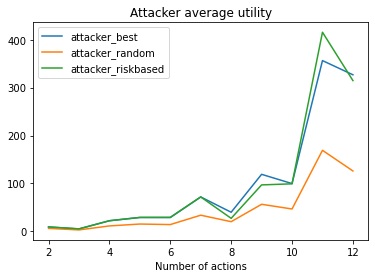

In [12]:
import matplotlib.pyplot as plt

fig = plt.figure()

ax = fig.add_subplot(1,1,1)
ax.set_title("Attacker average utility")
ax.set_xlabel("Number of actions")
# ax.set_yscale("symlog")
# ax.yaxis.set_major_locator(plt.LogLocator(base=10, numticks=5))
# ax.yaxis.set_major_locator(plt.MaxNLocator(100))
line, = ax.plot(x, y_attacker_best, label="attacker_best")
line, = ax.plot(x, y_attacker_average, label="attacker_random")
line, = ax.plot(x, y_attacker_riskbased, label="attacker_riskbased")
ax.legend()


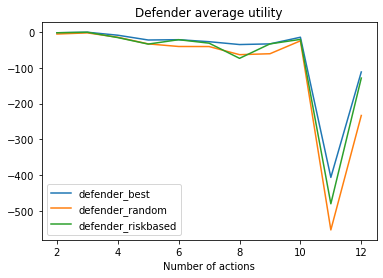

In [13]:
fig = plt.figure()

ax = fig.add_subplot(1,1,1)
ax.set_title("Defender average utility")
ax.set_xlabel("Number of actions")
# ax.set_yscale("symlog")
# ax.yaxis.set_major_locator(plt.LogLocator(base=10, numticks=5))
# ax.yaxis.set_major_locator(plt.MaxNLocator(100))
line, = ax.plot(x, y_defender_best, label="defender_best")
line, = ax.plot(x, y_defender_average, label="defender_random")
line, = ax.plot(x, y_defender_riskbased, label="defender_riskbased")
ax.legend()

In [14]:
y_defender_average

[-6.519999999999999,
 -0.9278000000000001,
 -3.845816888888889,
 -12.81139479708637,
 -40.61568531855956,
 -24.12903238815375,
 -75.30163722448981,
 -41.64851573069044,
 -59.990291395072,
 -195.1544174059707,
 -269.5041300092336]